# Parameter sensitivity

The major advantage that ``plscan`` brings is its automatic tuning of the
minimum cluster size. This notebook demonstrates the effects of the
``min_samples`` and ``min_cluster_size`` parameters in ``hdbscan`` and
``plscan``.

Let's load libraries and grab some data to demonstrate:

In [25]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from itertools import product
from scipy.stats import rankdata
from collections import defaultdict
from sklearn.datasets import fetch_openml

from umap import UMAP
from lensed_umap import embed_graph

from plscan import PLSCAN
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

from lib.plotting import *
from lib.drawing import regplot_lowess_ci


configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

## Cluster selection strategies

First, we will explain and compare the cluster selection strategies used by
HDBSCAN* and PLSCAN. The function below runs these algorithms and plots their
output in a nice overview, which is used in the explanations.

In [21]:
def plot_parameter_sweep(title, alg, **kwargs):
    """Plots the clusters and cluster hierarchies detected by the given
    algorithm at several min_samples / min_cluster_size values."""
    sized_fig(1, 0.8 / 5 * 2)
    for i, size in enumerate([2, 5, 10, 50, 100]):
        c = alg(min_samples=size, min_cluster_size=size, **kwargs).fit(data)
        plt.subplot(2, 5, i + 1)
        plot_kwargs = dict(s=1, cmap="tab10", vmax=9, vmin=0, edgecolors="none")
        plt.scatter(*data.T, c=c.labels_ % 10, **plot_kwargs)
        plt.title(f"$k={size}$", y=0.9)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, 5, i + 6)
        if alg == HDBSCAN:
            palette = plt.cm.tab10.colors
            c.condensed_tree_.plot(
                select_clusters=True,
                colorbar=False,
                leaf_separation=0.5,
                selection_palette=palette,
            )

        else:
            c.leaf_tree_.plot(select_clusters=True, colorbar=False, leaf_separation=0.5)
        plt.ylabel("")
        plt.yticks([])
    plt.subplot(2, 5, 6)
    if alg == PLSCAN:
        plt.ylabel("Min.~size", labelpad=0)
    else:
        plt.ylabel(r"$\lambda$ value", labelpad=0)
    plt.suptitle(title, y=1, fontsize=fontsize["normal"])
    plt.subplots_adjust(left=0.03, top=0.85, right=1, bottom=0, hspace=0, wspace=0.05)

### HDBSCAN* cluster selection

``hdbscan`` simplifies single linkage dendrograms using a minimum cluster size
to create a cluster hierarchy (`condensed_tree`). The cluster hierarchy forms a
*merge-tree* listing which connected components exist over all density values.
As density decreases, larger distance edges enter the filtration and create
connections between connected components, merging them in the hierarchy. The
process describes the data's 0-dimensional topology in a filtration over the
density, effectively implementing a *persistent homology* computation.

Clusters are selected from the hierarchy using one of two selection strategies.
The *leaf* strategy always selects the cluster tree's leaves. These clusters
correspond to all local density maxima meeting the size threshold. Effectively,
**this strategy defines clusters as local density maxima**. In practice,
leaf-clusters depend strongly on the minimum cluster size value used to
construct the cluster hierarchy. Many small leaf clusters can be detected for
small minimum cluster sizes, resulting in segmentations where most points are
classified as noise. 

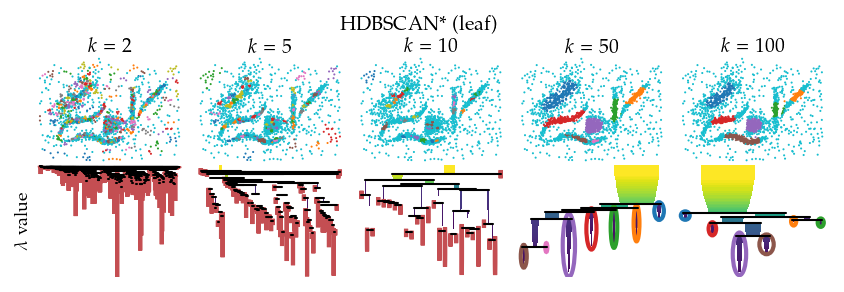

In [12]:
plot_parameter_sweep("HDBSCAN* (leaf)", HDBSCAN, cluster_selection_method="leaf")
plt.savefig("images/hdbscan_leaf_selection.pdf", pad_inches=0)
plt.show()

The *EOM* strategy is more statistically motivated. It encourages fewer, larger
clusters by **defining clusters as a neighborhoods with an excess of probability
mass** (explained by Müller & Sawitzki, 1991). In statistical terms, the *EOM*
strategy interprets the density profile as a probability distribution and
computes its *modality*. Specifically, the strategy selects connected components
from the hierarchy that maximize a (relative) stability measure. The stability
measure aggregates the density-ranges in which points are part of a particular
connected component. It combines the number of points contained in the component
with the points' *persistence* in the density filtration. Selecting the most
persistent structures from a filtration as the *true* signal is common in
*persistent homology* and clustering (see, *cluster lifetime* referenced by
Campello et al., 2015). The stability adapts this notion to a cluster with
changing membership over density (Campello et al., 2015). While *EOM* clusters
are less sensitive to the minimum cluster size, they vary enough that the
parameter needs to be tuned to avoid small low-density clusters. Notice that
some clusters disappear at larger size thresholds.

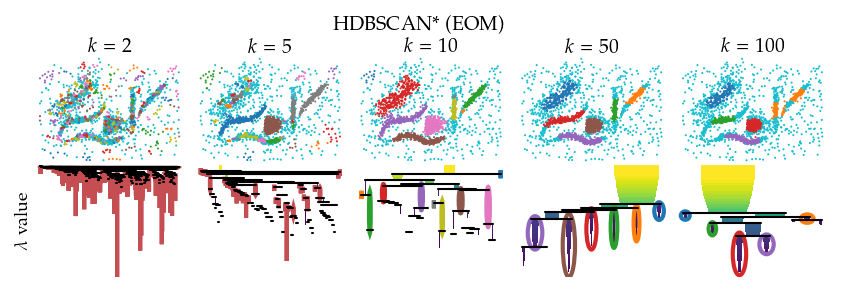

In [13]:
plot_parameter_sweep("HDBSCAN* (EOM)", HDBSCAN, cluster_selection_method="eom")
plt.savefig("images/hdbscan_eom_selection.pdf", pad_inches=0)
plt.show()

Both selection strategies can select clusters with varying densities that do not
correspond to a straight density-cut in the cluster hierarchy. In other words,
there may not be a single distance or density value for which DBSCAN produces
the same clusters.

### Persistent leaf-clusters

``plscan`` selects clusters by finding a minimum cluster size for which
leaf-clusters are optimal. Like *EOM*, the resulting clusters relate to the
density distributions modality, rather than all local maxima. 

The strategy performs a very efficient filtration over the minimum cluster size
parameter to create a leaf-cluster tree over all possible minimum cluster sizes.
It then finds the `min_cluster_size` parameter that maximizes a quality measure.
The result is **a (practically) parameter free clustering algorithm that
produces *EOM*-like clusters** and a cluster hierarchy describing leaf-clusters
at other size thresholds. 

The ``min_samples`` parameter in ``plscan`` smooths the computed density profile
which prunes small, low-persistent leaves from the the leaf-cluster tree. Unlike
``hdbscan``'s minimum cluster size parameter, **changing ``min_samples`` in
``plscan`` does not really change which clusters are selected**. At higher
`min_samples` the selected clusters becomes smaller, with more points classified
as noise. This suggests low `min_samples` values work better. However, at too
low values (i.e. `min_samples=2` below), the resulting clusters might to
sensitive to local density changes.

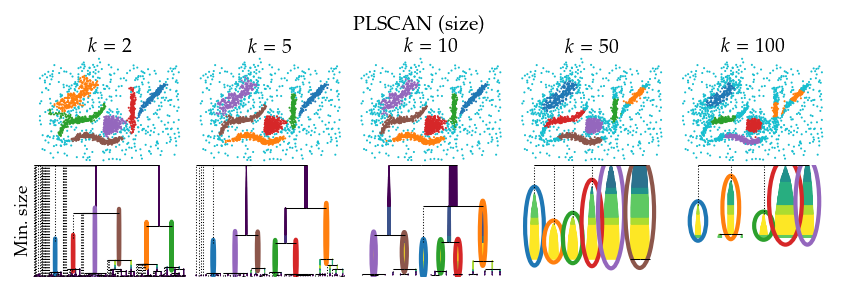

In [22]:
plot_parameter_sweep("PLSCAN (size)", PLSCAN)
plt.savefig("images/plscan_size_selection.pdf", pad_inches=0)
plt.show()

The other [persistence measures](./using_bi_persistences.ipynb) in ``plscan``
behave similarly:

- size--distance bi-persistence

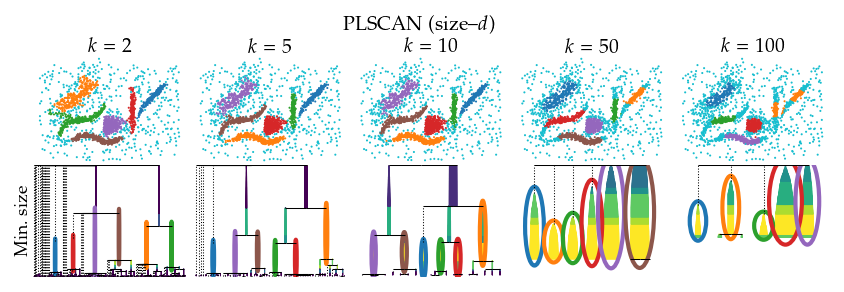

In [23]:
plot_parameter_sweep("PLSCAN (size--$d$)", PLSCAN, persistence_measure="size-distance")
plt.savefig("images/plscan_distance_selection.pdf", pad_inches=0)
plt.show()

- size--density bi-persistence

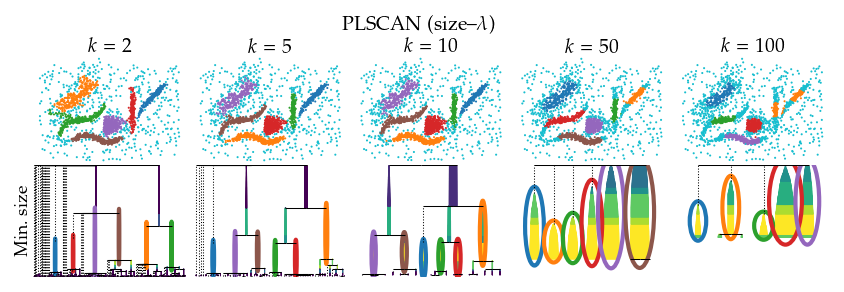

In [24]:
plot_parameter_sweep(
    "PLSCAN (size--$\\lambda$)", PLSCAN, persistence_measure="size-density"
)
plt.savefig("images/plscan_density_selection.pdf", pad_inches=0)
plt.show()

## Sensitivity analysis

A parameter sensitivity analysis comparing HDBSCAN and PLSCAN tells us how much
one can expect their output to change when changing $k$. The resulting value is
independent of $k$ itself. Instead it relates to a change in $k$: $\Delta k$!

[Peng et al. 2022](https://www.nature.com/articles/s41467-022-33136-9#Sec18)
used a parameter sensitivity analysis modified from "Latin-Hypercube
One-factor-At-a-Time (LH-OAT)" to evaluate their clustering algorithm. This
sounds more complicated than it is, especially for algorithms with a single
parameter. The steps are as follows:

- Choose a parameter $k$ and divided its value-space in regularly sized segments.
- Choose a constant perturbation $\Delta v$ to evaluate.
- Sample values $v$ in each segment. We denote the set of sampled values with
  $V$. 
- Perturb the sampled values with $\pm \Delta v$, randomly choosing the positive
  or negative direction.
- Compute the algorithm's clustering quality scores at $v$ and $v \pm \Delta v$.
  For example, using the
  [ARI](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html),
  we denote this score as $ARI(k=v)$, indicating a score at parameter value
  $k=v$.
- Compute the sensitivity at $\Delta v$ using: 
$$
  s_{\Delta v} = \frac{1}{|V|} \sum_{v \in V} \left|\frac{ARI(k=v \pm \Delta v) - ARI(k=v)} {ARI(k=v \pm\Delta v) + ARI(k=v)}\right|. 
$$

We want to evaluate the sensitivity for multiple perturbation sizes $\Delta v$,
algorithm configurations, and datasets. Our implementation splits the work in
three stages and considers several clustering quality measures:

1. Sample the parameter and perturbations, collecting all parameter values to
   evaluate.
2. Compute the algorithms' clustering quality measures values on all datasets
   with the collected parameter values. Store these values!
3. Use the computed quality measures values to compute average sensitivities for
   each perturbation size.

### 1. Sample parameter values and perturbations

This cell performs the parameter value sampling and applies perturbations at
multiple sizes. The process is repeated five times (vectorized) and all unique
parameter values required for the sensitivity computation are collected.

Perturbations that create invalid values (<2) are ignored!

In [ ]:
# configuration
repeats = 5
num_segments = 15
min_sample_range = (2, 500)
deltas = np.array([[5], [10], [15], [20]])

# sampled values
segments = np.linspace(*min_sample_range, num_segments + 1, dtype=int)
samples = np.random.uniform(segments[:-1], segments[1:], size=(repeats, num_segments))
min_sample_sizes = np.round(samples).astype(int).T

# perturbed values
directions = np.random.choice((-1, 1), size=(deltas.shape[0], num_segments, repeats))
perturbations = directions * deltas[:, :, np.newaxis]
new_values = min_sample_sizes[np.newaxis, :, :] + perturbations

# all values to evaluate
all_values = np.concatenate((min_sample_sizes.flatten(), new_values.flatten()))
all_values = np.unique(all_values)
all_values = all_values[(all_values >= 2)]

np.save("data/generated/benchmark_sensitivity_deltas.npy", deltas)
np.save("data/generated/benchmark_sensitivity_min_sizes.npy", min_sample_sizes)
np.save("data/generated/benchmark_sensitivity_perturbed_values.npy", new_values)

### 2. Compute quality measures

This stage computes the clustering quality measures values at the sampled
parameter values. We run multiple algorithm configurations on several data sets.

First, configure the datasets. This step assumes all dataset have been
downloaded and pre-processed before running this notebook. See instructions at
`docs/data/[data-set]/README.md`!

In [9]:
def load_mnist():
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def load_fashion_mnist():
    X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def load_20newsgroups():
    """See data/newsgroups/README.md for details."""
    X = np.load("data/newsgroups/generated/X_20newsgroups.npy")
    y = np.load("data/newsgroups/generated/y_20newsgroups.npy")
    return X, y.astype(np.intp)


def load_elegans():
    """See data/elegans/README.md for details."""
    X = np.load("data/elegans/generated/X_elegans.npy")
    y = np.load("data/elegans/generated/y_elegans.npy")
    return X, y.astype(np.intp)


def load_audioset_music():
    """See data/audioset/README.md for details."""
    X = np.load("data/audioset/generated/X_music.npy")
    y = np.load("data/audioset/generated/y_music.npy")
    return X, y.astype(np.intp)


data_configs = dict(
    mnist=load_mnist,
    fashion_mnist=load_fashion_mnist,
    newsgroups=load_20newsgroups,
    elegans=load_elegans,
    audioset_music=load_audioset_music,
)

Implement the clustering quality measures.

In [10]:
def compute_quality(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)
    mutual_info = 2.0 * homogeneity * completeness / (homogeneity + completeness)
    return ari, homogeneity, completeness, mutual_info

Create runners for the algorithms. These functions return one or more records
identifying the dataset, algorithm configuration, and resulting quality scores.

In [11]:
def evaluate_hdbscan(X, y, data_name, k, alg_name, params, post_params):
    labels = HDBSCAN(min_samples=k, min_cluster_size=k, **params).fit_predict(X)
    ari, homogeneity, completeness, mutual_info = compute_quality(y, labels)
    return [
        dict(
            ari=ari,
            homogeneity=homogeneity,
            completeness=completeness,
            mutual_info=mutual_info,
            data_set=data_name,
            k=k,
            alg_id="_".join([alg_name] + [f"{v}" for v in params.values()]),
            alg_config={"algorithm": alg_name, **params},
        )
    ]

For `plscan`, we compute scores for its top-$n$ layers:

In [12]:
def evaluate_plscan(X, y, data_name, k, alg_name, params, post_params):
    c = PLSCAN(min_samples=k, min_cluster_size=k, **params).fit(X)
    layers = c.cluster_layers(**post_params) or [(k, c.labels_, c.probabilities_)]
    sizes, pers = c._persistence_trace
    sizes = sizes if sizes.shape[0] > 0 else np.array([k], dtype=np.float32)
    pers = pers if pers.shape[0] > 0 else np.array([0.0], dtype=np.float32)
    s = [s for s, _, _ in layers]
    ranks = rankdata(-pers[np.searchsorted(sizes, s)], method="ordinal")
    records = []
    for peak, (size, labels, _) in zip(ranks, layers):
        ari, homogeneity, completeness, mutual_info = compute_quality(y, labels)
        records.append(
            dict(
                ari=ari,
                homogeneity=homogeneity,
                completeness=completeness,
                mutual_info=mutual_info,
                data_set=data_name,
                k=k,
                alg_id="_".join(
                    [alg_name] + [f"{v}" for v in params.values()] + [f"{peak}"]
                ),
                alg_config={
                    "algorithm": alg_name,
                    **params,
                    "peak": peak,
                    "birth_size": size,
                },
            )
        )
    return records

Specify the algorithm--parameter configurations:

In [13]:
# Configurations
algorithms = dict(plscan=evaluate_plscan, hdbscan=evaluate_hdbscan)
in_params = defaultdict(
    dict,
    plscan=dict(persistence_measure=["size", "size-distance", "size-density"]),
    hdbscan=dict(cluster_selection_method=["leaf", "eom"]),
)
post_params = defaultdict(dict, plscan=dict(n_peaks=[4]))
algorithm_configs = [
    (
        fun,
        name,
        {param: value for param, value in zip(in_params[name].keys(), param_values)},
        {
            param: value
            for param, value in zip(post_params[name].keys(), post_param_values)
        },
    )
    for name, fun in algorithms.items()
    for param_values in product(*in_params[name].values())
    for post_param_values in product(*post_params[name].values())
]

Run all algorithm--data set--$k$ combinations (takes about 3 hours). 

We project all datasets down to 50 dimension using UMAP. We slowly increase
UMAP's repulsion strength parameter to avoid self-intersections in the layout.
The `set_op_mix_ratio` parameter increases cluster separation in the layout.
This step could be tuned for each dataset to increase performance. We are mostly 
interested in parameter stability, so these settings are good enough.

In [ ]:
records = []

pbar = tqdm(total=len(data_configs) * len(all_values) * len(algorithm_configs))
for data_name, loader in data_configs.items():
    # Load the data
    X, y = loader()

    # Project down to 50 dimensions with UMAP.
    # Repeats the layout procedure with increasing repulsion to avoid overlaps
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = UMAP(
            n_components=50,
            n_neighbors=250,
            metric="cosine",
            set_op_mix_ratio=0.1,
            transform_mode="graph",
        ).fit(X)
        p = embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 1])

    # Evaluate the algorithms
    for k, (evaluator, alg_name, params, post_params) in product(
        all_values, algorithm_configs
    ):
        records.extend(
            evaluator(p.embedding_, y, data_name, k, alg_name, params, post_params)
        )
        pbar.update()


df = pd.DataFrame.from_records(records)
df.to_parquet("data/generated/benchmark_sensitivity.parquet")
df.head()

100%|██████████| 6800/6800 [2:58:37<00:00,  2.40s/it]   

,ari,homogeneity,completeness,mutual_info,data_set,k,alg_id,alg_config
0,0.190297,0.570541,0.590652,0.580422,mnist,5,plscan_size_4,"{'algorithm': 'plscan', 'persistence_measure':..."
1,0.920710,0.923450,0.897375,0.910226,mnist,5,plscan_size_1,"{'algorithm': 'plscan', 'persistence_measure':..."
2,0.657180,0.753125,0.933298,0.833587,mnist,5,plscan_size_2,"{'algorithm': 'plscan', 'persistence_measure':..."
3,0.432134,0.535315,0.929862,0.679466,mnist,5,plscan_size_3,"{'algorithm': 'plscan', 'persistence_measure':..."
4,0.128724,0.524443,0.547776,0.535856,mnist,5,plscan_size-distance_4,"{'algorithm': 'plscan', 'persistence_measure':..."


### 2.5 Plot the results

Configure column and value renaming for plots:

In [27]:
df = pd.read_parquet("data/generated/benchmark_sensitivity.parquet")
deltas = np.load("data/generated/benchmark_sensitivity_deltas.npy")
min_sample_sizes = np.load("data/generated/benchmark_sensitivity_min_sizes.npy")
new_values = np.load("data/generated/benchmark_sensitivity_perturbed_values.npy")

In [29]:
def digit_higher_than_one(char):
    return char.isdigit() and int(char) > 1


def to_display_name(input):
    parts = input.split("_")
    name = parts[0].upper()
    if name == "HDBSCAN":
        name = "HDBSCAN*"
        return f"{name} ({' '.join(parts[1:])})"
    if name == "PLSCAN":
        params = [
            p.replace("-", "--")
            .replace("density", r"$\lambda$")
            .replace("distance", "$d$")
            for p in parts[1:]
        ]
        return f"{name} ({' '.join(params)})"
    return input


display_names = {
    "ari": "ARI",
    "homogeneity": "Homogeneity",
    "completeness": "Completeness",
    "mutual_info": "Mutual info.",
    "alg_id": "Algorithm",
    "data_set": "Data set",
    "sensitivity": "Sensitivity",
    "perturbation": "Perturbation",
}

Keep only the default and best PLSCAN layer, where the best layer maximizes the
average mutual information over $k$.

In [30]:
# Remove non-default plscan layers
mask = df.alg_id.apply(lambda x: not digit_higher_than_one(x.split("_")[-1]))
df_default = df[mask].copy()
df_default.alg_id = df_default.alg_id.apply(
    lambda x: x if "plscan" not in x else "_".join(x.split("_")[:-1])
)

In [35]:
plscan_df = df.query("alg_id.str.startswith('plscan')", engine="python").copy()
plscan_df["persistence"] = plscan_df.alg_id.apply(lambda x: x.split("_")[1])
plscan_df["layer"] = plscan_df.alg_id.apply(lambda x: x.split("_")[-1])
best_layer = (
    plscan_df.groupby(["data_set", "persistence", "k"])
    .apply(lambda g: g.loc[g.mutual_info.idxmax()], include_groups=False)
    .reset_index()
)
best_layer.alg_id = best_layer.alg_id.apply(
    lambda x: "_".join(x.split("_")[:-1] + ["top"])
)
best_layer = best_layer.drop(columns=["layer", "persistence"])

In [36]:
# Combine dataframes
df_top = pd.concat((df_default, best_layer), ignore_index=True)
df_top.groupby(["data_set", "alg_id"]).apply(
    lambda g: g.loc[g.mutual_info.idxmax(), ["ari", "mutual_info"]],
    include_groups=False,
).reset_index().round(3).pivot(
    index="alg_id", columns="data_set", values=["ari", "mutual_info"]
)

ari                               \
data_set                 audioset_music elegans fashion_mnist  mnist   
alg_id                                                                 
hdbscan_eom                       0.071   0.366         0.444  0.941   
hdbscan_leaf                      0.021   0.310         0.079  0.683   
plscan_size                       0.042   0.364         0.415  0.931   
plscan_size-density               0.042   0.335         0.148  0.657   
plscan_size-density_top           0.042   0.336         0.457  0.931   
plscan_size-distance              0.042   0.335         0.148  0.657   
plscan_size-distance_top          0.042   0.336         0.457  0.931   
plscan_size_top                   0.042   0.333         0.457  0.931   

                                       mutual_info                        \
data_set                 newsgroups audioset_music elegans fashion_mnist   
alg_id                                                                     
hdbscan_eom                   0.099          0.275   0.671         0.660   
hdbscan_leaf                  0.053          0.250   0.641         0.409   
plscan_size                   0.088          0.261   0.651         0.608   
plscan_size-density           0.100          0.261   0.614         0.414   
plscan_size-density_top       0.065          0.261   0.662         0.632   
plscan_size-distance          0.096          0.261   0.614         0.414   
plscan_size-distance_top      0.095          0.261   0.662         0.632   
plscan_size_top               0.095          0.261   0.654         0.632   

                                            
data_set                  mnist newsgroups  
alg_id                                      
hdbscan_eom               0.925      0.411  
hdbscan_leaf              0.811      0.385  
plscan_size               0.917      0.390  
plscan_size-density       0.834      0.380  
plscan_size-density_top   0.917      0.398  
plscan_size-distance      0.834      0.395  
plscan_size-distance_top  0.917      0.396  
plscan_size_top           0.917      0.396

Plot mutual-info-$k$ curves

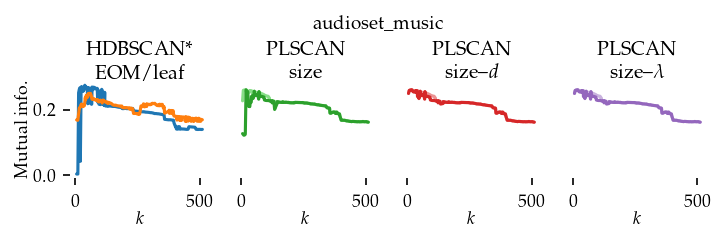

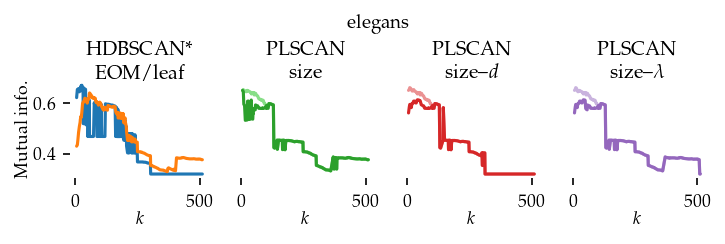

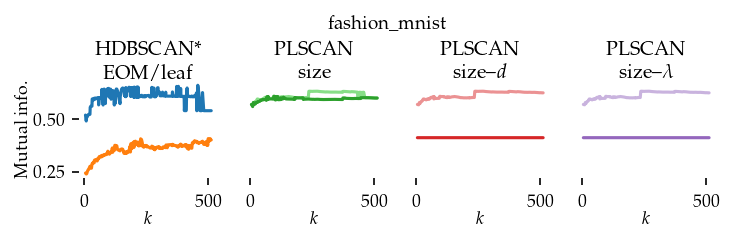

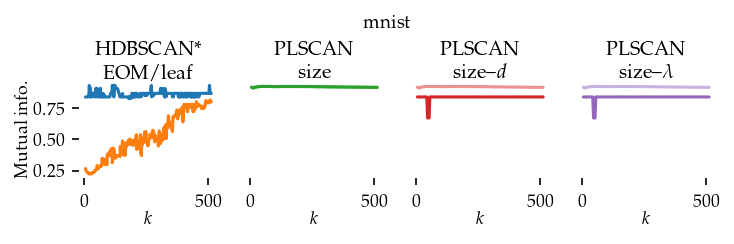

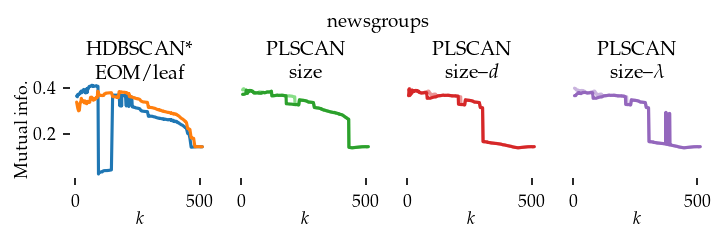

In [37]:
import colorsys
from matplotlib.colors import to_rgb


def lighten(color, amount=0.5):
    c = colorsys.rgb_to_hls(*to_rgb(color))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


plot_df = df_top.copy()
data_sets = sorted(plot_df.data_set.unique())
alg_ids = [
    "hdbscan_eom",
    "hdbscan_leaf",
    "plscan_size_top",
    "plscan_size",
    "plscan_size-distance_top",
    "plscan_size-distance",
    "plscan_size-density_top",
    "plscan_size-density",
]
palette = [
    to_rgb("C0"),
    to_rgb("C1"),
    lighten("C2"),  # lighten
    to_rgb("C2"),
    lighten("C3"),  # lighten
    to_rgb("C3"),
    lighten("C4"),  # lighten
    to_rgb("C4"),
]
titles = ["HDBSCAN*\nEOM/leaf", "PLSCAN\nsize", "PLSCAN\nsize--$d$", "PLSCAN\nsize--$\\lambda$"]

for i, data_name in enumerate(data_sets):
    sized_fig(1, 0.618 / 4)
    plt.suptitle(f"{data_name}", y=1.4)
    for j, ids in enumerate([[0, 1], [2, 3], [4, 5], [6, 7]]):
        plt.subplot(1, 4, j + 1)
        sns.lineplot(
            data=plot_df.query(f'data_set == "{data_name}"'),
            x="k",
            y="mutual_info",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            legend=False,
        )
        plt.title(titles[j], y=0.9)
        plt.xlabel("$k$", labelpad=0)
        if j == 0:
            plt.ylabel("Mutual info.", labelpad=0)
            ylim = plt.ylim()
        else:
            plt.ylim(ylim)
            plt.ylabel("")
            plt.yticks([])
plt.show()

Summarize the shape of these curves

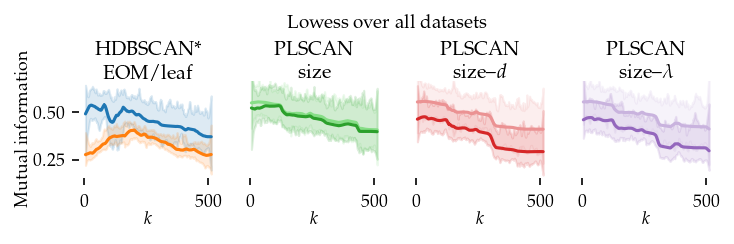

In [39]:
sized_fig(1, 0.618 / 4)
plt.suptitle("Lowess over all datasets", y=1.4)
for j, ids in enumerate([[0, 1], [2, 3], [4, 5], [6, 7]]):
    plt.subplot(1, 4, j + 1)
    for i, idx in enumerate(ids):
        alg_id = alg_ids[idx]
        regplot_lowess_ci(
            plot_df.query(f'alg_id == "{alg_id}"'),
            x="k",
            y="mutual_info",
            ci_level=99,
            n_boot=100,
            lowess_frac=0.05,
            scatter=False,
            color=palette[idx],
        )
        plt.title(titles[j], y=0.9)
        plt.xlabel("$k$", labelpad=0)
        if j == 0:
            plt.ylabel("Mutual information", labelpad=0)
            ylim = plt.ylim()
        else:
            plt.ylim(ylim)
            plt.ylabel("")
            plt.yticks([])
plt.show()

### 3. Compute sensitivity

Compare differences between the original and perturbed value to compute
clustering sensitivity at that perturbation size.

In [40]:
sensitivity_records = []
for data_set, alg_id in product(df_top.data_set.unique(), df_top.alg_id.unique()):
    sub_df = df_top.query(f"data_set == '{data_set}' & alg_id == '{alg_id}'")
    mut_infos = defaultdict(lambda: np.nan, {k: v for k, v in zip(sub_df.k, sub_df.mutual_info)})
    lookup_fun = np.vectorize(lambda x: mut_infos[x])
    initial_mut_info = lookup_fun(min_sample_sizes)[np.newaxis, :, :]
    perturbed_mut_info = lookup_fun(new_values)
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_mut_info - initial_mut_info) / (perturbed_mut_info + initial_mut_info))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_sens = pd.DataFrame.from_records(sensitivity_records)
df_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,mnist,plscan_size,5,0.000214
1,mnist,plscan_size,10,0.000342
2,mnist,plscan_size,15,0.000338
3,mnist,plscan_size,20,0.000370
4,mnist,plscan_size-distance,5,0.001476


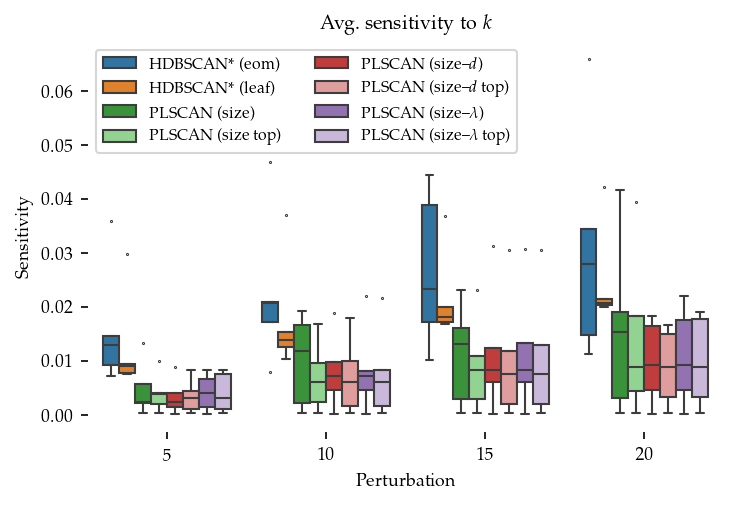

In [41]:
sized_fig(1)

plot_df = df_sens.copy()
plot_df.alg_id = plot_df.alg_id.apply(to_display_name)

alg_order = [0, 1, 3, 2, 5, 4, 7, 6]

ax = sns.boxplot(
    data=plot_df,
    y=plot_df.sensitivity,
    x=pd.Categorical(plot_df.perturbation),
    hue=plot_df.alg_id,
    hue_order=[to_display_name(alg_ids[x]) for x in alg_order],
    palette=[palette[x] for x in alg_order],
    fliersize=0.5,
    linewidth=1,
    legend=True,
)
plt.legend(ncol=2, title="", loc="upper left")
# plt.ylim([0, 1.3])
plt.title("Avg.~sensitivity to $k$")
plt.xlabel("Perturbation")
plt.ylabel("Sensitivity")
plt.show()